## Recuperación de Información
# Práctica 3.1 y 3.2 &mdash; Búsqueda Web y Recomendación - PageRank y Relevance Feedback
### Autores: *Enrique de Alvear Doñate, Óscar Calvet Sisó*

# 1.  Parte 1

## 1.1 Calcular PageRank en el subgrafo web formado por las páginas accesibles desde (e incluyendo) [esta dirección](http://arantxa.ii.uam.es/~abellogin/ir/C.html).

Tomar r = 0.1, N = nº de páginas en el subgrafo, y 0.3 como valor inicial de PageRank para empezar a iterar.

Nota: para grafos con pocos nodos, es también viable resolver la fórmula de PageRank como un sistema de ecuaciones, en lugar de iterar.

In [ ]:
from bs4 import BeautifulSoup as bs
from urllib.request import urlopen

inicial = "./C.html"


def BFS(url_init, header = "http://arantxa.ii.uam.es/~abellogin/ir/"):
  visitados = set()
  no_visitados = list()

  no_visitados.append(url_init)
  grafo = {}
  while len(no_visitados) > 0:
    actual = no_visitados.pop(0)
    page = bs(urlopen(header + actual[2:]), "html.parser")
    visitados.add(actual)
    grafo[actual]= []
    for link in page.find_all( href = True):
      if (link["href"] not in visitados) and (link["href"] not in no_visitados):
        no_visitados.append(link["href"])
      grafo[actual].append(link["href"])
  return grafo

def grafo_llegadas_(grafo):
  grafo_llegadas =  {}
  for nodo, lista_items in grafo.items():
    for nodo2 in lista_items:
      if nodo2 in grafo_llegadas.keys():
        grafo_llegadas[nodo2].append(nodo)
      else:
         grafo_llegadas[nodo2] = [nodo]
  return grafo_llegadas

def get_sumideros_(grafo):
  return [key for key,value in grafo.items() if value == []]

Las funciones implementadas anteriormente sirven de apoyo para el pageRank:

- BFS crea el grafo de las páginas web que se quieren estudiar, utilizando el algoritmo BFS.
- grafo_llegadas_: devuelve un grafo en el que para cada nodo, sus salidas significan que en el grafo original son llegadas.
- get_sumideros_: devuelve una lista de los sumideros del grafo.

In [ ]:
grafo = BFS(inicial)
print(grafo)

{'./C.html': ['./A.html', './D.html', './E.html'], './A.html': ['./B.html', './E.html'], './D.html': ['./C.html'], './E.html': ['./B.html'], './B.html': []}


Implementación del algoritmo de pageRank simple explicado en clase.

In [ ]:
import numpy as np

#PageRank Algoritmo Simple
def pageRank(grafo, r = 0.1):
  links_out = grafo_llegadas_(grafo)
  probs = {key : 0.3 for key in grafo.keys()}
  n = len(grafo)
  sumideros = get_sumideros_(grafo)
  anterior = np.ones(n)
  actual = np.asarray(list(probs.values()))
  while np.linalg.norm(anterior-actual) > 1e-20:
    new_probs = {key: r/n for key in grafo.keys()}
    #Calcular el sumando de los sumideros (constante para todos los nodos)
    sum_const = 0
    for key in sumideros:
      sum_const += probs[key]
    sum_const /= n
    for key in grafo.keys():
      cont = sum_const
      for out_node in links_out[key]:
        cont += probs[out_node]/len(grafo[out_node])
      new_probs[key] += (1-r)*cont
    anterior = np.asarray(list(probs.values()))
    actual = np.asarray(list(new_probs.values()))
    probs = new_probs
  return probs

Implementación del algoritmo pageRank en forma matricial.

In [ ]:
#PAge Rank algoritmo matricial
def pageRank_matrix(grafo, r = 0.1):
  n = len(grafo)
  hashTable = {list(grafo.keys())[i]:i for i in range(n)}
  S = np.array([np.zeros(n) for _ in range(n)])
  #Rellenar S
  for key in grafo.keys():
    if grafo[key] != []:
      val = 1/len(grafo[key])
      for out in grafo[key]:
        S[hashTable[key]][hashTable[out]] = val
    else:
      S[hashTable[key]] = np.ones(n)*1/n
  #Generar G
  G = r*S + (1-r)*1/n*np.outer(np.ones(n), np.ones(n))
  #Iterar
  ant = np.ones(n)*0.3
  pi = ant @ G
  while(np.linalg.norm(pi - ant) >= 1e-20):
      ant = pi
      pi = pi @ G
      pi = pi/np.sum(pi)
  probs = {key:pi[hashTable[key]] for key in grafo.keys()}
  return probs

In [ ]:
pageRank(grafo,0.9)

{'./C.html': 0.20338356291023388,
 './A.html': 0.1910572863702197,
 './D.html': 0.1910572863702197,
 './E.html': 0.2006101506887307,
 './B.html': 0.21389171366059595}

In [ ]:
pageRank_matrix(grafo,0.1)

{'./C.html': 0.20338356291023388,
 './A.html': 0.1910572863702197,
 './D.html': 0.1910572863702197,
 './E.html': 0.20061015068873067,
 './B.html': 0.21389171366059595}

Se puede ver que con ambas implementaciones la distribuciones límite son las mismas, el r es distinto para ambas implementaciones, por lo que se ha adaptado a corde a ello. A causa del cambio en las fórmulas de las diapositivas del r, las implementaciones intercambian los valores de r y (1-r), esto no afecta al algoritmo, consideramos el correcto es el implementado en forma matricial, que se refiere a la probabilidad de quedarse.

## 1.2 Cálculo de PageRank personalizado

Con los mismos parámetros del apartado anterior, personalizar PageRank para un usuario que tiene sólo las páginas 'A.html' y 'D.html' entre sus preferencias.

Modificamos el algoritmo de pageRank matricial ya que los cambios en la implementación se pueden realizar de forma más sencilla.

In [ ]:
def pageRankPer_matrix(grafo, preferences, r = 0.1):
  n = len(grafo)
  hashTable = {list(grafo.keys())[i]:i for i in range(n)}
  S = np.array([np.zeros(n) for _ in range(n)])
  # Generar v (vector preferencias)
  v = np.zeros(n)
  b = len(preferences)
  for pref in preferences:
    v[hashTable[pref]] = 1
  #Rellenar S
  for key in grafo.keys():
    if grafo[key] != []:
      val = 1/len(grafo[key])
      for out in grafo[key]:
        S[hashTable[key]][hashTable[out]] = val
    else:
      S[hashTable[key]] = np.ones(n)*1/n
  #Generar G usando v
  G = r*S + (1-r)*1/b*np.outer(np.ones(n), v)
  #Iterar
  ant = np.ones(n)*0.3
  pi = ant @ G
  while(np.linalg.norm(pi - ant) >= 1e-20):
      ant = pi
      pi = pi @ G
      pi = pi/np.sum(pi)
  probs = {key:pi[hashTable[key]] for key in grafo.keys()}
  return probs

In [ ]:
preferences = ['./A.html', './D.html']
pageRankPer_matrix(grafo,preferences, r=0.1)

{'./C.html': 0.04571507811777758,
 './A.html': 0.45203537641366986,
 './D.html': 0.45203537641366986,
 './E.html': 0.024637145234353338,
 './B.html': 0.02557702382052942}

Como se puede ver en la distribución límite, ya que las páginas A y D están favorecidas por la personalización entonces aumenta su probabilidad. Mientras que obviamente baja en las otras páginas. Esta fijación hacia esos dos nodos se debe a que $r=0.1$ lo cual implica que la tasa de salto a una página aleatoria es del $90\%$ es decir que la mayor parte de las visitas son aleatorias y al utilizar personalización, las probabilidades de salto no son uniformes, si no que se concentran en A y D, se puede ver claramente en los resultados, ya que la suma de las probabilidades de A y D es del $90\%$.

## Opcional 1.A

Probar valores distintos de r para calcular PageRank.

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

report = pd.DataFrame(columns=['r', 'page', 'rank'])
for m in range(0,11):
  r = 0.1*m
  ranking = pageRank(grafo, r=1-r)
  for key,value in ranking.items():
    report.loc[len(report.index)] = [r,key[2],value]

In [ ]:
report['rank'] = round(report['rank'],3)
report['r'] = round(report['r'], 2)

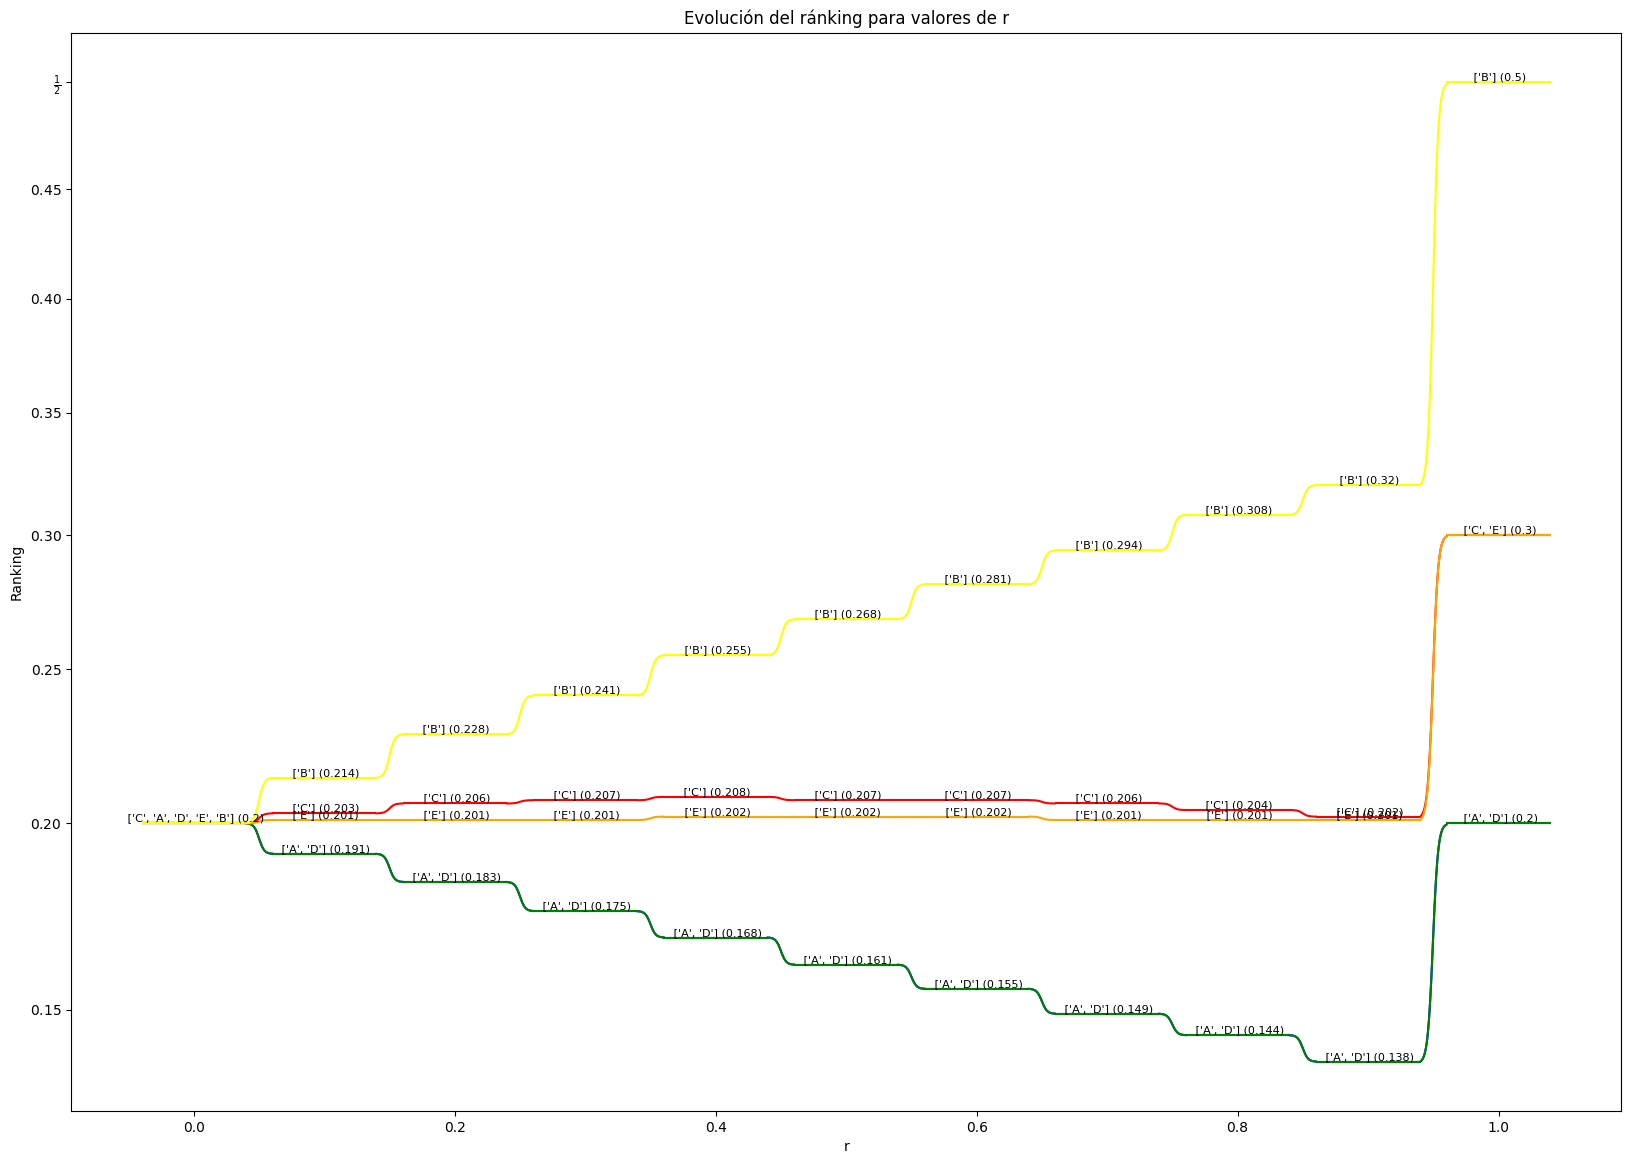

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator


# Set up the plot
fig, ax = plt.subplots(figsize=(20, 14))

# Determine the x-axis position for each year
rate_positions = {rate: pos for pos, rate in enumerate(report.r.unique())}
page_color = {page:color for page,color in zip(report.page.unique(),['r', 'b', 'g', 'orange', 'yellow'])}

def hanging_line(x, y, beta=1):
    x_ = np.linspace(-5, 5)
    x_adj = np.linspace(*x)
    sig = 1/(1+np.exp(-x_*beta))
    sig = (sig-sig.min())/sig.max()
    sig_adj = sig *(y[1]-y[0]) + y[0]
    return x_adj, sig_adj

# Draw horizontal lines for each ranking
for _, row in report.iterrows():
    x = rate_positions[row['r']]
    ax.hlines(y=row['rank'], xmin=x - 0.4, xmax=x + 0.4, color=page_color[row['page']])

#Dibujar curvas
for page in report.page.unique():
    extremes = report[report.page == page]
    lista = list(extremes['rank'])
    for i in range(len(lista)-1):
      x,y = hanging_line([i+0.4, i+1-0.4], [lista[i],lista[i+1]])
      ax.plot(x,y, c=page_color[page])


# Add annotations
for index, row in pd.DataFrame(report.groupby(['r', 'rank'])['page'].apply(list)).iterrows():
    ax.text(rate_positions[index[0]], index[1], f" {row['page']} ({round(index[1], 3)})", va='bottom', ha='center', fontsize=8)

# Set up the x-axis
ax.set_xticks(range(len(rate_positions)))
ax.set_xticklabels(rate_positions.keys())
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.set_yscale('logit')

# Add titles and labels
ax.set_title('Evolución del ránking para valores de r')
ax.set_xlabel('r')
ax.set_ylabel('Ranking')

plt.show()

Se puede ver en esta gráfica el cambio de la probabilidad según el r. Al principio, con r = 0, la distribución es uniforme, pero a medida que aumenta hasta 1 la distribución va cambiando, el nodo B va aumentando su probabilidad (es razonable puesto que es un sumidero, mientras que los nodos A y D van disminuyéndola (lo cual también es razonable ya que son solo nodos de paso). Las distribuciones de C y E no varían mucho. Cuando $r=1$ el algoritmo es equivalente a realizar un paseo aleatorio por el grafo descrito más abajo (añadiendo las conexiones de los sumideros). Es interesante destacar que la distribución límite obtenida al ir aumentando $r$ no converge a la distribución del paseo aleatorio.

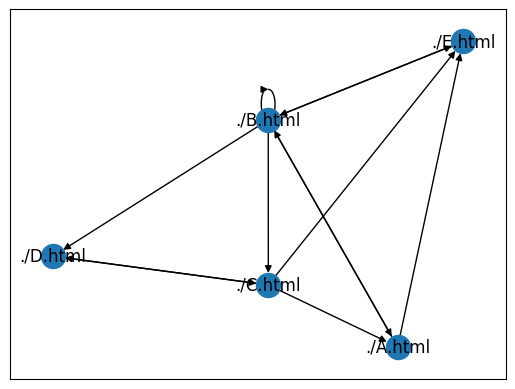

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt

G = nx.DiGraph(directed = True)
aux = [("./B.html", "./A.html"), ("./B.html", "./B.html"), ("./B.html", "./C.html"), ("./B.html", "./D.html"), ("./B.html", "./E.html")]
for node, value in grafo.items():
  for val in value:
    aux.append((node, val))
G.add_edges_from(aux)
nx.draw_networkx(G, arrows = True)

# 2.  Parte 2

## 2.1 Cálculo de relevance feedback

Sobre alguna consulta que hayas usado en prácticas anteriores (para la que tengas calculada los valores de TF-IDF), aplicar relevance feedback (una iteración) según las siguientes opciones.

1. Sistema/ránking de partida
    1. Google (obtenido en el proceso de recogida de datos).
    2. Modelo vectorial (VSM obtenido en la práctica 3 ej. 1).
    3. PRP modelo BIR ó document likelihood modelo 1 ó 2.
2. Técnica RF a usar:
    1. Para Google y VSM, expansión de consulta por el método Rocchio.
    2. Para los modelos probabilísticos, uso del conjunto de documentos feedback en la reestimación de probabilidades, según corresponde a cada método.
3. Fuente de feedback:
    * i) Clicks como feedback de relevancia implícita positiva usando el log de clicks de la práctica 2.
    * ii) Pseudo-relevance feedback (PRF): los documentos top n devueltos por el propio sistema. Nota: esta es la opción natural de BIR y document likelihood, pero tienen igualmente sentido el uso de clicks o juicios de relevancia (como prueba de concepto).
    * iii) Oráculo: juicios de relevancia (de la práctica 2) como feedback explícito de relevancia positiva y negativa. Nota: esta opción no corresponde a un escenario real (donde el feedback lo daría un usuario final en lugar de un asesor) ni a una evaluación “justa” en laboratorio (pues le enseñamos al sistema las “soluciones” a la pregunta sobre la que va a ser evaluado), pero sirve como prueba de contraste con las otras opciones.

Quedan a criterio del estudiante:
 - Los parámetros alfa, beta y gamma en Rocchio.
 - La profundidad del cutoff top-n en PRF.
 - El número de términos en la expansión de consultas y el criterio para seleccionarlos.

Observación: en el apartado 1.1, la interfaz de Google no contempla la ponderación de términos de consulta, de modo que se añadirán a la consulta términos sin peso. Cabría considerar pesos enteros (p.e. multiplicando los pesos por una constante y redondeándolos), que se pueden plasmar como términos repetidos en la consulta. El estudiante puede experimentar si lo desea con esta idea.

Cogemos la query 3 de la practica 2

Para este ejercicio se va a utilizar el modelo vectorial implementado en prácticas anteriores, una expansión de consulta por el método de Rocchio y el uso de un oráculo que se utilizará en el momento de usar Rocchio como fuente de feedback.

Primero se cargarán los datos como se hizo en la práctica 2, cogiendo únicamente las webs de google para evitar duplicados en las webs. Se hace un tratamiento de las webs para poder transformarlas en texto y poder utilizarlo para el VSM.


In [ ]:
import numpy as np
from google.colab import auth
import pandas as pd
import time

auth.authenticate_user()
import gspread
from google.auth import default
creds, _ = default()
gc = gspread.authorize(creds)

def read_sheet(wb, name, cols=False, colnames=False, coltypes=False):
  df = pd.DataFrame(wb.worksheet(name).get_all_values())[1:]
  if cols: df = df[df.columns[cols]]
  if colnames: df.columns = colnames
  if coltypes: df = df.astype(coltypes)
  return df

# Nos conectamos a la hoja de cálculo
wb = gc.open_by_url('https://docs.google.com/spreadsheets/d/1c6I2FafjKS1HlGXhYaOM2w1oqsgI7eqDOELQ3Nv7y-M')
print('Reading data...')

# Leemos los rankings
print('  Reading tab', 'Rankings', end='')
rankings = read_sheet(wb, 'Rankings', [0,1,2,3,4], ['qid', 'docid', 'pos', 'score', 'system'], {'qid':'int', 'pos':'int', 'score':'int'})#rankings
rankings = rankings[rankings.docid != '']
print('..... ok')

# Leemos los juicios de relevancia
print('  Reading relevance judgment tabs', end='')
qrels = pd.concat([read_sheet(wb, ws.title, [0, 1, 2], ['qid', 'docid', 'rel'], {'qid':'int'})#juicios de relevancia
                   for ws in wb.worksheets() if ws.title.startswith('Acierto q')]).reset_index(drop=True)
print('..... ok')

# Comprobamos duplicados
pd.set_option('display.max_colwidth', 50)
duplicates = qrels[qrels.duplicated(['qid', 'docid'])]
if duplicates.size: print('\nDuplicate relevance judgments\n-----------------------------\n',
                          duplicates.to_string(index=False, max_colwidth=70))

# Comprobamos que coincidan las URLs en los rankings y juicios de relevancia
# (y de paso hacemos un join en ranking_rels para facilitar la implementación de métricas)
qm = qrels.merge(rankings, how='left')
ranking_rels = rankings.merge(qrels, how='left')
missing = ranking_rels[pd.isna(ranking_rels.rel)]
if missing.size: print('\nMissing relevance judgments\n---------------------------\n',
                       missing[['qid', 'docid']].to_string(index=False, max_colwidth=100))
missing = qm[pd.isna(qm.pos)]
if missing.size: print('\nMissing results\n---------------\n',
                       missing[['qid', 'docid']].to_string(index=False, max_colwidth=100))
ranking_rels["rel"]=ranking_rels["rel"].fillna(0)
ranking_rels["rel"]=ranking_rels["rel"].astype(float).astype(int)

Reading data...
  Reading tab Rankings..... ok
  Reading relevance judgment tabs..... ok


En esta celda siguiente se especifica que query es la que queremos tratar de las que se utilizaron en la práctica 2 y se ha de especificar que qid tenía dicha query.


In [ ]:

q = "que pasa cuando pego una tostada a un gato y lo tiro por la ventana"
qid = 2
urls = ranking_rels[(ranking_rels["qid"] == qid) & (ranking_rels["system"] == "google")]["docid"]


In [ ]:
import requests
from urllib.request import urlopen
from bs4 import BeautifulSoup
from collections import Counter
import re

urls = urls.values
valid_url = []
import requests
texts = []
for url in urls:
  try:
    response = requests.get(url)
    texts.append(BeautifulSoup(response.content, "lxml").text.lower())
    valid_url.append(url)
  except:
    print(f"La url: {url} no es accesible")

#texts = [BeautifulSoup(urlopen(url).read(), "lxml").text.lower() for url in urls]

stoplist = ["also", "could", "p", "pp", "th", "however", "one", "two", "many", "i", "de", "la", "me", "my", "myself", "the", "we", "our", "ours", "ourselves", "you", "your", "yours", "yourself", "yourselves", "he", "him", "his", "himself", "she", "her", "hers", "herself", "it", "its", "itself", "they", "them", "their", "theirs", "themselves", "what", "which", "who", "whom", "this", "that", "these", "those", "am", "is", "are", "was", "were", "be", "been", "being", "have", "has", "had", "having", "do", "does", "did", "doing", "a", "an", "the", "and", "but", "if", "or", "because", "as", "until", "while", "of", "at", "by", "for", "with", "about", "against", "between", "into", "through", "during", "before", "after", "above", "below", "to", "from", "up", "down", "in", "out", "on", "off", "over", "under", "again", "further", "then", "once", "here", "there", "when", "where", "why", "how", "all", "any", "both", "each", "few", "more", "most", "other", "some", "such", "no", "nor", "not", "only", "own", "same", "so", "than", "too", "very", "s", "t", "can", "will", "just", "don", "should", "now"]


La url: http://elsecretodeberlanga.rf.gd/2017/09/24/la-paradoja-del-gato-y-la-tostada/ no es accesible


In [ ]:
freqvector = {url:Counter([word for word in re.findall(r"[^\W\d_]+|\d+", text) if word not in stoplist]) for url, text in zip(valid_url, texts)}

# Guardamos el vocabulario (el conjunto de todas las palabras que apaercen en los documentos de la colección).
vocabulary = set()
for word in freqvector.values(): vocabulary.update(word)

# Document frequency de cada palabra del vocabulario: nº de documentos que contienen la palabra.
docfreqs = {word:len([url for url in freqvector if word in freqvector[url]]) for word in vocabulary}

# Frecuencia total para cada palabra del vocabulario: nº total de apariciones en la colección.
wordfreqs = {word:sum([freqvector[url][word] for url in freqvector if word in freqvector[url]]) for word in vocabulary}

In [ ]:
from math import log2, sqrt

class VSM:
  def __init__(self, freqvector, docfreqs):
    self.freqvector = freqvector
    self.docfreqs = docfreqs

  def search(self, q):
    # Calculamos los cosenos de todos los documentos.
    ranking = [(url, self.dotproduct(url, q) / self.module(url)) if self.module(url) != 0 else (url,0) for url in self.freqvector]
    # Eliminamos los documentos con coseno = 0.
    #ranking = [(url, cos) for url, cos in ranking if cos > 0]
    # Ordenamos.
    ranking.sort(key=lambda x: x[1], reverse=True)
    return ranking

  def dotproduct(self, url, q):
    result = 0
    for word in q:
      result += self.tf(word, url) * self.idf(word)
    return result


  def module(self, url):
    result = 0
    for word in self.freqvector[url]:
      result += self.freqvector[url][word]**2
    return sqrt(result)



  def tf(self, word, url):
    if self.freqvector[url][word] > 0:
      return (1+log2(self.freqvector[url][word]))
    else:
      return 0


  def idf(self,word):
    try:
      self.docfreqs[word]
      return (log2(len(self.freqvector) + 0.5) / (self.docfreqs[word])+1)
    except:
      return 0


def tratamiento(q):
  aux = []
  for word in q.split():
    if word not in stoplist:
      aux.append(word)
  return aux

Ya con el tratamiento de los textos de las distintas urls procedemos a hacer un ranking inicial con la VSM implementada en la práctica 1.

In [ ]:
modelo = VSM(freqvector, docfreqs)

ranking_VSM = modelo.search(tratamiento(q))
ranking_VSM

[('https://es.quora.com/Si-un-gato-cae-siempre-de-pie-y-una-tostada-con-mantequilla-cae-siempre-por-el-lado-en-que-est%C3%A1-untada-que-pasar%C3%ADa-si-le-atas-a-un-gato-en-la-espalda-una-tostada-con-la-mantequilla-hacia-arriba-y-luego-lo',
  2.295629276423073),
 ('https://es.quora.com/Si-una-tostada-con-mantequilla-cae-siempre-en-el-lado-de-la-mantequilla-y-un-gato-cae-siempre-de-pie-Si-peg%C3%A1ramos-una-tostada-de-mantequilla-en-la-espalda-de-un-gato-no-cae',
  1.8021301033711683),
 ('https://www.advance-affinity.com/es/es/gato/consejos/el-sindrome-del-gato-paracaidista',
  1.0178096748215466),
 ('https://www.lasexta.com/programas/arusitys/tremendo-susto-que-pega-gato-cuando-tostadas-salen-disparadas-tostadora_2023111865586ff0f6ca720001270a32.html',
  0.9573486927002407),
 ('https://webs.ucm.es/BUCM/blogs/InfoMat/4968.php', 0.6792256721154222),
 ('https://www.webconsultas.com/mascotas/primeros-auxilios-para-mascotas/caida-libre-en-gatos-como-actuar',
  0.5425507711943592),
 ('https:

Aquí se procede a utilizar el algoritmo de Rocchio para intentar mejorar el ranking hecho por la VSM, para ello calcularemos el tf-idf de los textos, separando primero por los relevantes y los no relevantes, esta es la parte donde el Oráculo interviene ya que aquí es donde tenemos que saber cuales son los relevantes y tienen importancia.

In [ ]:
relev = ranking_rels[(ranking_rels["qid"] == qid) & (ranking_rels["system"] == "google") & (ranking_rels["rel"] > 0)].drop(100, axis = 0)
no_relev = ranking_rels[(ranking_rels["qid"] == qid) & (ranking_rels["system"] == "google") & (ranking_rels["rel"] == 0)]

def tf(word, url, freqvector):
    if freqvector[url][word] > 0:
      return (1+log2(freqvector[url][word]))
    else:
      return 0

def idf(word, docfreqs, freqvector):
    try:
      docfreqs[word]
      return (log2(len(freqvector) + 0.5) / (docfreqs[word])+1)
    except:
      return 0

def module( url, freqvector):
    result = 0
    for word in freqvector[url]:
      result += freqvector[url][word]**2
    return sqrt(result)


Se calcula primero un vector_q inicial, el cual representa la query como un vector de idf, y se calcula para cada uno de las url relevantes y no relevantes su propio vector de tf.

In [ ]:
vector_q = [idf(word,docfreqs, freqvector) if word in docfreqs.keys() else 0 for word in tratamiento(q)]

vec_rel ={}

for url in relev["docid"]:
  vec_rel[url]= [tf(word, url, freqvector) if word in freqvector[url].keys() else 0 for word in tratamiento(q)]


vec_no_rel = {}
for url in no_relev["docid"]:
  vec_no_rel[url] =[tf(word, url, freqvector) if word in freqvector[url].keys() else 0 for word in tratamiento(q)]


Se aplica la fórmula de Rocchio

\begin{equation}
q_{new} = \alpha \cdot q + \frac{\beta}{| D_r |} \cdot \sum_{d_j \in D_r}d_j - \frac{\gamma}{|D_{n}|}\cdot \sum_{d_j \in D_n}d_j
\end{equation}

In [ ]:
alpha = 1
beta = 1
gamma = 1

q_new = alpha * np.array(vector_q) + beta * np.array(list(vec_rel.values())).sum(axis = 0) / len(vec_rel) - gamma * np.array(list(vec_no_rel.values())).sum(axis = 0) / len(vec_no_rel)

Finalmente se calcula el nuevo ranking utilizando el nuevo vector de query.

In [ ]:

ranking_relevantes = [(url, (q_new * np.array(vec)).sum() / module(url, freqvector)) if module(url, freqvector) != 0 else (url,0) for url, vec in vec_rel.items()]
ranking_no_relevantes = [(url, (q_new * np.array(vec)).sum() / module(url, freqvector)) if module(url, freqvector) != 0 else (url,0) for url, vec in vec_no_rel.items()]
ranking_RF = ranking_relevantes + ranking_no_relevantes
ranking_RF.sort(key=lambda x: x[1], reverse=True)
print(ranking_RF)


[('https://es.quora.com/Si-una-tostada-con-mantequilla-cae-siempre-en-el-lado-de-la-mantequilla-y-un-gato-cae-siempre-de-pie-Si-peg%C3%A1ramos-una-tostada-de-mantequilla-en-la-espalda-de-un-gato-no-cae', 2.065929560901684), ('https://es.quora.com/Si-un-gato-cae-siempre-de-pie-y-una-tostada-con-mantequilla-cae-siempre-por-el-lado-en-que-est%C3%A1-untada-que-pasar%C3%ADa-si-le-atas-a-un-gato-en-la-espalda-una-tostada-con-la-mantequilla-hacia-arriba-y-luego-lo', 2.025302561981246), ('https://webs.ucm.es/BUCM/blogs/InfoMat/4968.php', 0.5554177782660165), ('https://www.advance-affinity.com/es/es/gato/consejos/el-sindrome-del-gato-paracaidista', 0.4995037565869204), ('https://ztfnews.wordpress.com/2011/12/05/la-paradoja-del-gato-y-la-tostada/', 0.4200269428401949), ('https://www.lasexta.com/programas/arusitys/tremendo-susto-que-pega-gato-cuando-tostadas-salen-disparadas-tostadora_2023111865586ff0f6ca720001270a32.html', 0.4152398903358381), ('https://www.webconsultas.com/mascotas/primeros-aux

## 2.2 Comparar efectividad

Comparar la efectividad de los ránkings resultantes de aplicar relevance feedback en comparación con el ránking inicial, en términos de precisión y nDCG.

Nota: para Google (apartado 2.1), el propio estudiante tendrá que añadir juicios de relevancia a los nuevos documentos que pueda devolver Google para la consulta expandida.

Hay que poner el ranking final del relevance feedback y comparar la p@10 y el nDCG entre los dos rankings

In [ ]:
# TODO´
ranking_df_VSM = pd.DataFrame(columns = ["docid",  "pos" ,"rel"],  index=range(len(ranking_VSM)))
for i in range(len(ranking_VSM)):
  ranking_df_VSM.iloc[i] = (ranking_VSM[i][0], float(i+1), float(ranking_rels[ranking_rels["docid"] == ranking_VSM[i][0]]["rel"].values[0]))

print("Ranking con VSM")
print(ranking_df_VSM.head(10))
print("\n_______________________________\n")


ranking_df_RF = pd.DataFrame(columns = ["docid",  "pos" ,"rel"],  index=range(len(ranking_RF)))
for i in range(len(ranking_RF)):
  ranking_df_RF.iloc[i] = (ranking_RF[i][0], float(i+1), float(ranking_rels[ranking_rels["docid"] == ranking_RF[i][0]]["rel"].values[0]))
print("Ranking con relevance feedback")
print(ranking_df_RF.head(10))

def prec(ranking, max_len):
  aux = ranking.copy().iloc[:max_len]
  aux['rel'] = aux['rel'].apply(lambda x : 1 if x > 0 else 0)
  return aux["rel"].mean()

def DCG(ranking):
  rk = ranking.copy()
  aux = rk["rel"] / np.log2((rk["pos"] +1).astype(float))
  rk["DCG"] = aux
  return rk["DCG"].sum()

def IDCG(ranking):
  rk = ranking.copy()
  rk = pd.DataFrame(rk.sort_values(['rel'], ascending=[False]))
  rk["pos"] = np.arange(1,ranking['pos'].nunique()+1)
  aux = rk["rel"] / np.log2(rk["pos"] +1)
  rk["IDCG"] = aux
  return rk['IDCG'].sum()

def nDCG_(ranking):
  return DCG(ranking) / IDCG(ranking)

Ranking con VSM
                                               docid  pos  rel
0  https://es.quora.com/Si-un-gato-cae-siempre-de...  1.0  2.0
1  https://es.quora.com/Si-una-tostada-con-manteq...  2.0  1.0
2  https://www.advance-affinity.com/es/es/gato/co...  3.0  0.0
3  https://www.lasexta.com/programas/arusitys/tre...  4.0  0.0
4    https://webs.ucm.es/BUCM/blogs/InfoMat/4968.php  5.0  1.0
5  https://www.webconsultas.com/mascotas/primeros...  6.0  0.0
6  https://ztfnews.wordpress.com/2011/12/05/la-pa...  7.0  2.0
7  https://urgenciesveterinaries.com/gato-caido-v...  8.0  0.0
8  https://www.contrib.andrew.cmu.edu/~norm/Steve...  9.0  0.0

_______________________________

Ranking con relevance feedback
                                               docid  pos  rel
0  https://es.quora.com/Si-una-tostada-con-manteq...  1.0  1.0
1  https://es.quora.com/Si-un-gato-cae-siempre-de...  2.0  2.0
2    https://webs.ucm.es/BUCM/blogs/InfoMat/4968.php  3.0  1.0
3  https://www.advance-affinity.com/e

In [ ]:
print(f"prec para ranking VSM:{prec(ranking_df_VSM, 5)}")
print(f"nDCG para ranking VSM:{nDCG_(ranking_df_VSM)}")
print(f"prec para ranking VSM con relevance feedback:{prec(ranking_df_RF, 5)}")
print(f"nDCG para ranking VSM con relevance feedback:{nDCG_(ranking_df_RF)}")

prec para ranking VSM:0.6
nDCG para ranking VSM:0.878811576134306
prec para ranking VSM con relevance feedback:0.8
nDCG para ranking VSM con relevance feedback:0.843299870678533


Se puede ver que aunque el nDCG con relevance feedback ha bajado ligeramente, la precisión ha aumentado en un 20%, esto se debe a que en el ranking con RF intercambia la posición en el ranking final de una web con relevancia 2 por una de relevancia 1, pero en cambio consigue que en los primeros 5 puestos del ranking el 80% de las web son relevantes, en contraste con el VSM usual que solo tiene un 60% de relevantes. Por lo que se puede concluir que realmente el uso del relevance feedback ha afectado de forma positiva a los resultados, mejorando el ranking obtenido.

## 2.3 Informe

Escribir un informe con los resultados y detalles de los métodos y fórmulas aplicados, así como las diferencias observadas entre los resultados de las diferentes opciones y modelos.

Como se ha ido comentando a lo largo de este punto se ha estudiado el uso de relevance feedback para la mejora de búsqueda, se ha utilizado para ello como algoritmo de ranking VSM y como método de mejora de la query el algoritmo dado por la fórmula de Rocchio, la fuente del feedback ha sido un oráculo por el cual se ha visto qué documentos son relevantes para la query y cuales no.

Primero se ha rankeado las urls utilizando VSM simplemente, calculado el tf-idf.

A continuación se ha procedido a intentar mejorar el ranking utilzando el feedback. Se ha separado las url entre las relevantes y las que no son relevantes gracias a los datos utilizados en la práctica 2. Se ha calculado el vector de la query utilizando tf, y se ha calculado el vector de cada una de las url con respecto al de la query usando idf.

Con estos vectores, utilizando la fórmula de Rocchio
\begin{equation}
q_{new} = \alpha \cdot q + \frac{\beta}{| D_r |} \cdot \sum_{d_j \in D_r}d_j - \frac{\gamma}{|D_{n}|}\cdot \sum_{d_j \in D_n}d_j
\end{equation}
Con parámetros  $\alpha = 1, \beta =1, \gamma = 1$

Se ha recalcualado el vector de la query y se ha utilizado para conseguir un nuevo ranking. Estudiando con $prob@5$ (ya que $prob@10$ no daba resultados relevantes ya que solo teníamos 10 urls entre las que estudiar por lo que siempre da el mismo resultado da igual el ranking), y con $nDCG$, con lo que se ha podido concluir que hay una mejora considerable en el ranking si se utiliza el relevance feedback para la mejora del vector de query, obteniendo para nuestro caso de aplicación una mejora del 20% en precisión.

## Opcional 2.A

Probar a realizar varias iteraciones de relevance feedback en aquellos métodos donde sea viable y/o tenga más sentido (p.e. es más difícil con buscadores comerciales, ya que entrarían nuevos documentos de los que habría que extraer el vector de palabras, y -salvo para PRF- obtener nuevos clicks y/o juicios de relevancia).

In [ ]:
# TODO
#Seguir iterando con lo anterior


vector_q = [idf(word,docfreqs, freqvector) if word in docfreqs.keys() else 0 for word in tratamiento(q)]
for _ in range(3):
  vec_rel ={}

  for url in relev["docid"]:
    vec_rel[url]= [tf(word, url, freqvector) if word in freqvector[url].keys() else 0 for word in tratamiento(q)]


  vec_no_rel = {}
  for url in no_relev["docid"]:
    vec_no_rel[url] =[tf(word, url, freqvector) if word in freqvector[url].keys() else 0 for word in tratamiento(q)]

  alpha = 1
  beta = 1
  gamma = 1

  vector_q = alpha * np.array(vector_q) + beta * np.array(list(vec_rel.values())).sum(axis = 0) / len(vec_rel) - gamma * np.array(list(vec_no_rel.values())).sum(axis = 0) / len(vec_no_rel)

q_new = vector_q

ranking_relevantes = [(url, (q_new * np.array(vec)).sum() / module(url, freqvector)) if module(url, freqvector) != 0 else (url,0) for url, vec in vec_rel.items()]
ranking_no_relevantes = [(url, (q_new * np.array(vec)).sum() / module(url, freqvector)) if module(url, freqvector) != 0 else (url,0) for url, vec in vec_no_rel.items()]
ranking_RF = ranking_relevantes + ranking_no_relevantes
ranking_RF.sort(key=lambda x: x[1], reverse=True)


ranking_df_RF_iter = pd.DataFrame(columns = ["docid",  "pos" ,"rel"],  index=range(len(ranking_RF)))
for i in range(len(ranking_RF)):
  ranking_df_RF_iter.iloc[i] = (ranking_RF[i][0], float(i+1), float(ranking_rels[ranking_rels["docid"] == ranking_RF[i][0]]["rel"].values[0]))
print("Ranking con relevance feedback iterado")
print(ranking_df_RF_iter.head(10))
print("\n__________________________\n")
print(f"prec para ranking VSM con relevance feedback iterado:{prec(ranking_df_RF_iter, 5)}")
print(f"nDCG para ranking VSM con relevance feedback iterado:{nDCG_(ranking_df_RF_iter)}")

Ranking con relevance feedback iterado
                                               docid  pos  rel
0  https://es.quora.com/Si-una-tostada-con-manteq...  1.0  1.0
1  https://es.quora.com/Si-un-gato-cae-siempre-de...  2.0  2.0
2    https://webs.ucm.es/BUCM/blogs/InfoMat/4968.php  3.0  1.0
3  https://ztfnews.wordpress.com/2011/12/05/la-pa...  4.0  2.0
4  https://www.contrib.andrew.cmu.edu/~norm/Steve...  5.0  0.0
5  https://urgenciesveterinaries.com/gato-caido-v...  6.0  0.0
6  https://www.webconsultas.com/mascotas/primeros...  7.0  0.0
7  https://www.advance-affinity.com/es/es/gato/co...  8.0  0.0
8  https://www.lasexta.com/programas/arusitys/tre...  9.0  0.0

__________________________

prec para ranking VSM con relevance feedback iterado:0.8
nDCG para ranking VSM con relevance feedback iterado:0.8642054753803928


Los resultados obtenidos aunque no mucho mejores que el obtenido con una única iteración se puede ver que el nDCG ha mejorado ligeramente y el ranking ha mejorado poniendo en las primeras 4 posiciones webs relevantes, cosa que no se había conseguido en los intentos anteriores.


## Opcional 2.B

Probar valores diferentes de alfa, beta y gamma en Rocchio, diferentes cutoff en PRF, y/o diferente nº de términos de expansión.

In [ ]:
# TODO
#cambiar los parámetros y probar
# TODO
#Seguir iterando con lo anterior


vector_q = [idf(word,docfreqs, freqvector) if word in docfreqs.keys() else 0 for word in tratamiento(q)]
for _ in range(3):
  vec_rel ={}

  for url in relev["docid"]:
    vec_rel[url]= [tf(word, url, freqvector) if word in freqvector[url].keys() else 0 for word in tratamiento(q)]


  vec_no_rel = {}
  for url in no_relev["docid"]:
    vec_no_rel[url] =[tf(word, url, freqvector) if word in freqvector[url].keys() else 0 for word in tratamiento(q)]

  alpha = 1
  beta = 0
  gamma = 0.5

  vector_q = alpha * np.array(vector_q) + beta * np.array(list(vec_rel.values())).sum(axis = 0) / len(vec_rel) - gamma * np.array(list(vec_no_rel.values())).sum(axis = 0) / len(vec_no_rel)

q_new = vector_q

ranking_relevantes = [(url, (q_new * np.array(vec)).sum() / module(url, freqvector)) if module(url, freqvector) != 0 else (url,0) for url, vec in vec_rel.items()]
ranking_no_relevantes = [(url, (q_new * np.array(vec)).sum() / module(url, freqvector)) if module(url, freqvector) != 0 else (url,0) for url, vec in vec_no_rel.items()]
ranking_RF = ranking_relevantes + ranking_no_relevantes
ranking_RF.sort(key=lambda x: x[1], reverse=True)


ranking_df_RF_iter = pd.DataFrame(columns = ["docid",  "pos" ,"rel"],  index=range(len(ranking_RF)))
for i in range(len(ranking_RF)):
  ranking_df_RF_iter.iloc[i] = (ranking_RF[i][0], float(i+1), float(ranking_rels[ranking_rels["docid"] == ranking_RF[i][0]]["rel"].values[0]))
print(f"Ranking con relevance feedback iterado con parámetros:\n alpha = {alpha}\n beta = {beta}\n gamma = {gamma}")
print(ranking_df_RF_iter.head(10))
print("\n__________________________\n")
print(f"prec para ranking VSM con relevance feedback iterado:{prec(ranking_df_RF_iter, 5)}")
print(f"nDCG para ranking VSM con relevance feedback iterado:{nDCG_(ranking_df_RF_iter)}")

# TODO
#Seguir iterando con lo anterior


vector_q = [idf(word,docfreqs, freqvector) if word in docfreqs.keys() else 0 for word in tratamiento(q)]
for _ in range(3):
  vec_rel ={}

  for url in relev["docid"]:
    vec_rel[url]= [tf(word, url, freqvector) if word in freqvector[url].keys() else 0 for word in tratamiento(q)]


  vec_no_rel = {}
  for url in no_relev["docid"]:
    vec_no_rel[url] =[tf(word, url, freqvector) if word in freqvector[url].keys() else 0 for word in tratamiento(q)]

  alpha = 1
  beta = 1.5
  gamma = 0

  vector_q = alpha * np.array(vector_q) + beta * np.array(list(vec_rel.values())).sum(axis = 0) / len(vec_rel) - gamma * np.array(list(vec_no_rel.values())).sum(axis = 0) / len(vec_no_rel)

q_new = vector_q

ranking_relevantes = [(url, (q_new * np.array(vec)).sum() / module(url, freqvector)) if module(url, freqvector) != 0 else (url,0) for url, vec in vec_rel.items()]
ranking_no_relevantes = [(url, (q_new * np.array(vec)).sum() / module(url, freqvector)) if module(url, freqvector) != 0 else (url,0) for url, vec in vec_no_rel.items()]
ranking_RF = ranking_relevantes + ranking_no_relevantes
ranking_RF.sort(key=lambda x: x[1], reverse=True)


ranking_df_RF_iter = pd.DataFrame(columns = ["docid",  "pos" ,"rel"],  index=range(len(ranking_RF)))
for i in range(len(ranking_RF)):
  ranking_df_RF_iter.iloc[i] = (ranking_RF[i][0], float(i+1), float(ranking_rels[ranking_rels["docid"] == ranking_RF[i][0]]["rel"].values[0]))
print(f"Ranking con relevance feedback iterado con parámetros:\n alpha = {alpha}\n beta = {beta}\n gamma = {gamma}")
print(ranking_df_RF_iter.head(10))
print("\n__________________________\n")
print(f"prec para ranking VSM con relevance feedback iterado:{prec(ranking_df_RF_iter, 5)}")
print(f"nDCG para ranking VSM con relevance feedback iterado:{nDCG_(ranking_df_RF_iter)}")

# TODO
#Seguir iterando con lo anterior


vector_q = [idf(word,docfreqs, freqvector) if word in docfreqs.keys() else 0 for word in tratamiento(q)]
for _ in range(3):
  vec_rel ={}

  for url in relev["docid"]:
    vec_rel[url]= [tf(word, url, freqvector) if word in freqvector[url].keys() else 0 for word in tratamiento(q)]


  vec_no_rel = {}
  for url in no_relev["docid"]:
    vec_no_rel[url] =[tf(word, url, freqvector) if word in freqvector[url].keys() else 0 for word in tratamiento(q)]

  alpha = 0
  beta = 1.5
  gamma = 1.5

  vector_q = alpha * np.array(vector_q) + beta * np.array(list(vec_rel.values())).sum(axis = 0) / len(vec_rel) - gamma * np.array(list(vec_no_rel.values())).sum(axis = 0) / len(vec_no_rel)

q_new = vector_q

ranking_relevantes = [(url, (q_new * np.array(vec)).sum() / module(url, freqvector)) if module(url, freqvector) != 0 else (url,0) for url, vec in vec_rel.items()]
ranking_no_relevantes = [(url, (q_new * np.array(vec)).sum() / module(url, freqvector)) if module(url, freqvector) != 0 else (url,0) for url, vec in vec_no_rel.items()]
ranking_RF = ranking_relevantes + ranking_no_relevantes
ranking_RF.sort(key=lambda x: x[1], reverse=True)


ranking_df_RF_iter = pd.DataFrame(columns = ["docid",  "pos" ,"rel"],  index=range(len(ranking_RF)))
for i in range(len(ranking_RF)):
  ranking_df_RF_iter.iloc[i] = (ranking_RF[i][0], float(i+1), float(ranking_rels[ranking_rels["docid"] == ranking_RF[i][0]]["rel"].values[0]))
print(f"Ranking con relevance feedback iterado con parámetros:\n alpha = {alpha}\n beta = {beta}\n gamma = {gamma}")
print(ranking_df_RF_iter.head(10))
print("\n__________________________\n")
print(f"prec para ranking VSM con relevance feedback iterado:{prec(ranking_df_RF_iter, 5)}")
print(f"nDCG para ranking VSM con relevance feedback iterado:{nDCG_(ranking_df_RF_iter)}")


Ranking con relevance feedback iterado con parámetros:
 alpha = 1
 beta = 0
 gamma = 0.5
                                               docid  pos  rel
0  https://www.contrib.andrew.cmu.edu/~norm/Steve...  1.0  0.0
1  https://urgenciesveterinaries.com/gato-caido-v...  2.0  0.0
2  https://ztfnews.wordpress.com/2011/12/05/la-pa...  3.0  2.0
3  https://www.webconsultas.com/mascotas/primeros...  4.0  0.0
4    https://webs.ucm.es/BUCM/blogs/InfoMat/4968.php  5.0  1.0
5  https://www.advance-affinity.com/es/es/gato/co...  6.0  0.0
6  https://www.lasexta.com/programas/arusitys/tre...  7.0  0.0
7  https://es.quora.com/Si-una-tostada-con-manteq...  8.0  1.0
8  https://es.quora.com/Si-un-gato-cae-siempre-de...  9.0  2.0

__________________________

prec para ranking VSM con relevance feedback iterado:0.4
nDCG para ranking VSM con relevance feedback iterado:0.5496381282123429
Ranking con relevance feedback iterado con parámetros:
 alpha = 1
 beta = 1.5
 gamma = 0
                                  

Variando los parámetros de la fórmula de Rocchio se puede ver que en general son todos importantes ya que bajando cualquiera menor que 1 se obtienen peores resulados, por lo que es recomendable como se tiene en los apuntes que los parámetros de Rocchio al menos para este caso sean 1 todos.


## Opcional 2.C

Probar con diferentes consultas y comparar si los resultados que se obtienen son consistentes con los obtenidos usando la consulta de los primeros apartados.

In [ ]:
# TODO
#Probar con otras búsquedas
q = "vscode-clangd vs intellisense"
qid = 4
urls = ranking_rels[(ranking_rels["qid"] == qid) & (ranking_rels["system"] == "google")]["docid"]



urls = urls.values
valid_url = []
texts = []
for url in urls:
  try:
    response = requests.get(url)
    texts.append(BeautifulSoup(response.content, "lxml").text.lower())
    valid_url.append(url)
  except:
    print(f"La url: {url} no es accesible")


stoplist = ["also", "could", "p", "pp", "th", "however", "one", "two", "many", "i", "de", "la", "me", "my", "myself", "the", "we", "our", "ours", "ourselves", "you", "your", "yours", "yourself", "yourselves", "he", "him", "his", "himself", "she", "her", "hers", "herself", "it", "its", "itself", "they", "them", "their", "theirs", "themselves", "what", "which", "who", "whom", "this", "that", "these", "those", "am", "is", "are", "was", "were", "be", "been", "being", "have", "has", "had", "having", "do", "does", "did", "doing", "a", "an", "the", "and", "but", "if", "or", "because", "as", "until", "while", "of", "at", "by", "for", "with", "about", "against", "between", "into", "through", "during", "before", "after", "above", "below", "to", "from", "up", "down", "in", "out", "on", "off", "over", "under", "again", "further", "then", "once", "here", "there", "when", "where", "why", "how", "all", "any", "both", "each", "few", "more", "most", "other", "some", "such", "no", "nor", "not", "only", "own", "same", "so", "than", "too", "very", "s", "t", "can", "will", "just", "don", "should", "now"]


freqvector = {url:Counter([word for word in re.findall(r"[^\W\d_]+|\d+", text) if word not in stoplist]) for url, text in zip(valid_url, texts)}

# Guardamos el vocabulario (el conjunto de todas las palabras que apaercen en los documentos de la colección).
vocabulary = set()
for word in freqvector.values(): vocabulary.update(word)

# Document frequency de cada palabra del vocabulario: nº de documentos que contienen la palabra.
docfreqs = {word:len([url for url in freqvector if word in freqvector[url]]) for word in vocabulary}

# Frecuencia total para cada palabra del vocabulario: nº total de apariciones en la colección.
wordfreqs = {word:sum([freqvector[url][word] for url in freqvector if word in freqvector[url]]) for word in vocabulary}

modelo = VSM(freqvector, docfreqs)

ranking_VSM = modelo.search(tratamiento(q))

relev = ranking_rels[(ranking_rels["qid"] == qid) & (ranking_rels["system"] == "google") & (ranking_rels["rel"] > 0)]
no_relev = ranking_rels[(ranking_rels["qid"] == qid) & (ranking_rels["system"] == "google") & (ranking_rels["rel"] == 0)]

vector_q = [idf(word,docfreqs, freqvector) if word in docfreqs.keys() else 0 for word in tratamiento(q)]
for _ in range(3):
  vec_rel ={}

  for url in relev["docid"]:
    vec_rel[url]= [tf(word, url, freqvector) if word in freqvector[url].keys() else 0 for word in tratamiento(q)]


  vec_no_rel = {}
  for url in no_relev["docid"]:
    vec_no_rel[url] =[tf(word, url, freqvector) if word in freqvector[url].keys() else 0 for word in tratamiento(q)]

  alpha = 1
  beta = 0
  gamma = 0.5

  vector_q = alpha * np.array(vector_q) + beta * np.array(list(vec_rel.values())).sum(axis = 0) / len(vec_rel) - gamma * np.array(list(vec_no_rel.values())).sum(axis = 0) / len(vec_no_rel)

q_new = vector_q

ranking_relevantes = [(url, (q_new * np.array(vec)).sum() / module(url, freqvector)) if module(url, freqvector) != 0 else (url,0) for url, vec in vec_rel.items()]
ranking_no_relevantes = [(url, (q_new * np.array(vec)).sum() / module(url, freqvector)) if module(url, freqvector) != 0 else (url,0) for url, vec in vec_no_rel.items()]
ranking_RF = ranking_relevantes + ranking_no_relevantes
ranking_RF.sort(key=lambda x: x[1], reverse=True)


ranking_df_RF_iter = pd.DataFrame(columns = ["docid",  "pos" ,"rel"],  index=range(len(ranking_RF)))
for i in range(len(ranking_RF)):
  ranking_df_RF_iter.iloc[i] = (ranking_RF[i][0], float(i+1), float(ranking_rels[ranking_rels["docid"] == ranking_RF[i][0]]["rel"].values[0]))

ranking_df_VSM = pd.DataFrame(columns = ["docid",  "pos" ,"rel"],  index=range(len(ranking_VSM)))
for i in range(len(ranking_VSM)):
  ranking_df_VSM.iloc[i] = (ranking_VSM[i][0], float(i+1), float(ranking_rels[ranking_rels["docid"] == ranking_VSM[i][0]]["rel"].values[0]))

print("Ranking con VSM")
print(ranking_df_VSM.head(10))
print("\n\n")
print(f"prec para ranking VSM:{prec(ranking_df_VSM, 5)}")
print(f"nDCG para ranking VSM:{nDCG_(ranking_df_VSM)}")
print("\n_______________________________\n")

print(f"Ranking con relevance feedback iterado con parámetros:\n alpha = {alpha}\n beta = {beta}\n gamma = {gamma}")
print(ranking_df_RF_iter.head(10))
print("\n\n")
print(f"prec para ranking VSM con relevance feedback iterado:{prec(ranking_df_RF_iter, 5)}")
print(f"nDCG para ranking VSM con relevance feedback iterado:{nDCG_(ranking_df_RF_iter)}")

Ranking con VSM
                                               docid   pos  rel
0  https://stackoverflow.com/questions/77958376/v...   1.0  1.0
1     https://code.visualstudio.com/docs/cpp/faq-cpp   2.0  0.0
2  https://github.com/microsoft/vscode-cpptools/i...   3.0  0.0
3  https://code.visualstudio.com/docs/cpp/configu...   4.0  0.0
4  https://www.kdab.com/supercharging-vs-code-wit...   5.0  0.0
5      https://news.ycombinator.com/item?id=22625968   6.0  2.0
6  https://marketplace.visualstudio.com/items?ite...   7.0  0.0
7  https://www.reddit.com/r/cpp_questions/comment...   8.0  2.0
8                           https://clangd.llvm.org/   9.0  0.0
9  https://medium.com/@mehmet-mert-gunduz/enhance...  10.0  2.0



prec para ranking VSM:0.2
nDCG para ranking VSM:0.6225788656327798

_______________________________

Ranking con relevance feedback iterado con parámetros:
 alpha = 1
 beta = 0
 gamma = 0.5
                                               docid   pos  rel
0  https://www.reddit.c

Utilizando otra query del conjunto de datos utilizado se puede ver que también se consiguen mejores resultados con el uso de la fórmula de Rocchio para el relevance feedback